# Applying Hybrid Monte-Carlo (HMC) to the long range Ising model
A Hybrid Monte-Carlo algorithm is used to study the dynamics of a long range 2d spin lattice and compared with analytically obtained results. Also a leap-frog integration is implemented in the process of the HMC algorithm. Bootstrap methods are used for error analysis of computed observables. 

## Theory
*The expectation value of some operator $O$ is given by
$$\langle O \rangle = \frac{1}{Z}\int \text{d}\phi O[\phi]e^{-S[\phi]}$$ Use the expression above and the fact that the mean magnetization (per site) and energy (per
site) are given by $$\langle m\rangle=\frac{T}{N}\frac{\partial\log Z}{\partial h },$$
$$\langle \varepsilon\rangle-\frac{1}{N}\frac{\partial\log Z}{\partial \beta }$$
to derive corresponding expressions for $O[\phi]$ for these quantities.*

Doing the math yields:
$$m[\phi]=\frac{1}{\sqrt{2\pi\beta J}}\tanh{(\beta h \pm \phi)}$$
$$\varepsilon[\phi]=-\frac{1}{\sqrt{2\pi\beta J}N}\left(\frac{\phi^2}{2\beta^2J}+h\cdot\tanh(\beta h \pm \phi)\right)$$

We encounter the following artificial Hamiltonian in the process of the HMC algorithm:

$$\mathcal{H}=\frac{p^2}{2}+\frac{\phi^2}{2\beta J}-N\log(2\cosh(\beta h + \phi))$$

*Determine the equations of motion (EoMs) for this Hamiltonian by applying the
Hamilton equations*

$$\dot{p}=-\frac{\partial\mathcal{H}}{\partial\phi}=-\left(\frac{\phi}{\beta J}-N\cdot\tanh(\beta h + \phi)\right)$$
$$\dot{\phi}=\frac{\partial\mathcal{H}}{\partial p}=p$$


$$\mathcal{H}=\frac{p^2}{2}+\frac{\phi^2}{2\beta J}-N\log(2\cosh(\beta h + \phi))$$


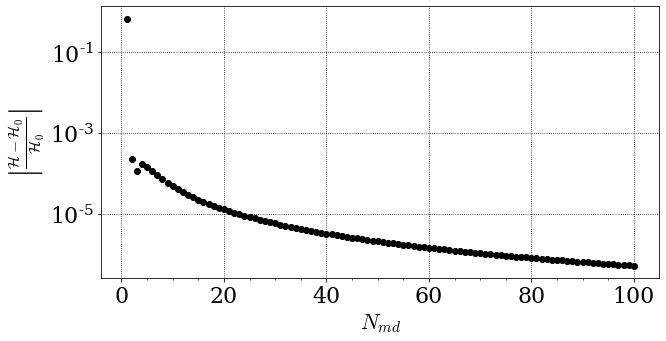

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc

T=1
beta=1/T
J=1
N=8
h=1
#pretty plots
def beauty_plot():
    plt.figure(figsize=(10,5))
    plt.minorticks_on()
    plt.rcParams["mathtext.fontset"]="cm"
    plt.rcParams['errorbar.capsize'] = 3
    plt.rcParams['mathtext.rm'] = 'serif'
    font={'family' : 'serif','size'   : 22}
    plt.rc("font",**font)
    plt.xticks(fontsize=22,fontname='DejaVu Serif')
    plt.yticks(fontsize=22,fontname='DejaVu Serif')
    plt.grid(color='black',linestyle=':')

def leap_frog(N_md, p_0, phi_0, J):
    epsilon = 1/N_md
    p, phi = p_0, phi_0
    #first leap-frog step
    phi = phi+epsilon/2*p
    for i in range(0,N_md-1):
        p=p-epsilon*(phi/(beta*J)-N*np.tanh(beta*h+phi))
        phi=phi+epsilon*p
    #last step of leap-frog
    p=p-epsilon*(phi/(beta*J)-N*np.tanh(beta*h+phi))
    phi=phi+epsilon/2*p
    return p, phi

def art_hamiltonian(p, phi,J, N):
    return p**2/2+phi**2/(2*beta*J)-N*np.log(2*np.cosh(beta*h+phi))

p_0=1
phi_0=1
hamiltonian_0=art_hamiltonian(p_0,phi_0,J/N ,N)
hamiltonian=[]
for i in range(1,101):
    p, phi = leap_frog(i,p_0,phi_0, J/N)
    hamiltonian.append(np.abs((art_hamiltonian(p,phi,J/N,N)-hamiltonian_0)/hamiltonian_0))
beauty_plot()
plt.plot(np.linspace(1,100,100),hamiltonian,'o',c="black")    
plt.yscale("log")    
plt.xlabel("$N_{md}$")
plt.ylabel("$\\left|\\frac{\\mathcal{H}-\\mathcal{H}_0}{\\mathcal{H}_0}\\right|$")
plt.show()

### Implementing HMC 
$$\varepsilon[\phi]=-\frac{1}{\sqrt{2\pi\beta J}N}\left(\frac{\phi^2}{2\beta^2J}+h\cdot\tanh(\beta h \pm \phi)\right)$$
$$m[\phi]=\frac{1}{\sqrt{2\pi\beta J}}\tanh{(\beta h \pm \phi)}$$


In [29]:
nTrajs = 4000
N_md = 100
N = 8
h=0.5

def numerical(J):
    phi_list = [1]
    m_observe = []
    energy_observe = []
    for traj in range(nTrajs):
        p_0 = np.random.normal(0,1)
        phi_0 = phi_list[-1]
        hamiltonian_0 = art_hamiltonian(p_0, phi_0, J/N, N)
        # Calculate p' and phi'
        p, phi = leap_frog(N_md,p_0,phi_0, J/N)
        hamiltonian = art_hamiltonian(p, phi, J/N, N)
        if np.random.uniform(0,1)<=np.exp(-beta*(hamiltonian-hamiltonian_0)):
            phi_list.append(phi)
        else:
            phi_list.append(phi_0)
            
    # Measurments
    m = []
    energy = []
    for phi in phi_list:
        m.append(1/(np.sqrt(2*np.pi*beta*J/N))*np.tanh(beta*h+phi))
        energy.append(-1/(np.sqrt(2*np.pi*beta*J/N)*N)*(phi**2/(2*beta**2*J/N)+h*np.tanh(beta*h+phi)))
        
    return np.mean(m), np.mean(energy)


J_list = np.array(np.linspace(0.2,2,15))
m_observed = []
energy_observed = []

for J in J_list:
    m, energy = numerical(J)
    m_observed.append(m)
    energy_observed.append(energy)


### Analytical approach


In [66]:
def f_func(x,J,N):
    return np.exp(1/2*beta*J/N*x**2+beta*h*x)

def Z_func(J, N):
    f_sum = 0
    N_list = np.linspace(1, N, N)
    for n in N_list:
        f_sum += sc.binom(N, n)*f_func(N-2*n,J, N)
    return np.exp(1/2*beta*J/N)*f_sum

def energy_analytical(J, N):
    energy_sum = 0
    N_list = np.linspace(1, N, N)
    for n in N_list:
        energy_sum += sc.binom(N, n)*(1/2*beta*J/N*(N-2*n)**2+beta*h*(N-2*n))*f_func(J, N-2*n, N)
    return -1/(N*Z_func(J, N))*energy_sum

def m_analytical(J, N):
    m_sum = 0
    N_list = np.linspace(0, N, N)
    for n in N_list:
        m_sum += sc.binom(N, n)* f_func(N-2*n, J, N)
    return 1/(N*Z_func(J, N))*m_sum

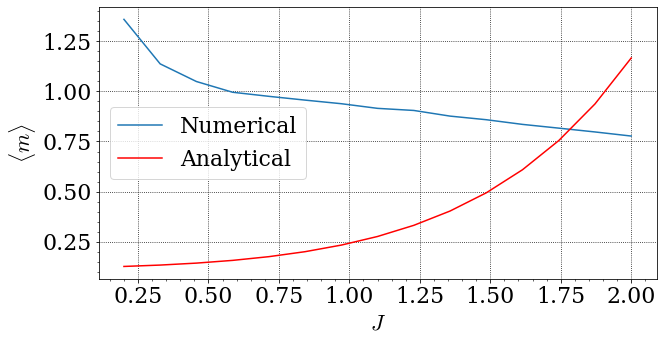

In [70]:
beauty_plot()
plt.plot(J_list, m_observed, label="Numerical")
plt.plot(J_list, m_analytical(J_list, N), c="red", label = "Analytical")
plt.xlabel("$J$")
plt.ylabel("$\\langle m \\rangle$")
plt.legend()
plt.show()

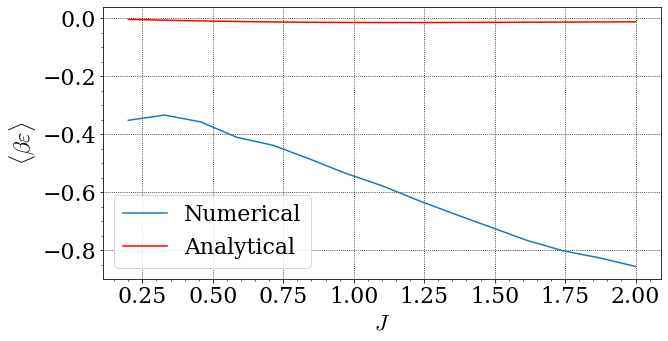

In [71]:
beauty_plot()
plt.plot(J_list, energy_observed, label = "Numerical")
plt.plot(J_list, energy_analytical(J_list, N), c="red", label = "Analytical")
plt.xlabel("$J$")
plt.ylabel("$\\langle \\beta\\varepsilon \\rangle$")
plt.legend()
plt.show()
